In [229]:
import numpy as np 
import os, json
from os.path import isdir, join
from functools import cmp_to_key
import itertools
import matplotlib.pyplot as plt 

In [230]:
import scipy
import scipy.stats as st
from scipy.special import gamma as gammaf
class scoreGenerator:
    def __init__(self, path, useML = False):
        with open (join(path, 'profInfoDB.json')) as handle: # read in prof info 
            self.profDB = json.load(handle)
        self.scores = np.array([score for score in self.profDB.values() if score !=[]])
        self.scores[:,0] = self.scores[:,0]/5 # normalize avg score 
        self.useML = useML
        if useML == False: # fit distribution to data, used for cold start 
            self.__fit_distribution()
        else: # not implemented yet
            self.__train_naive_bayes() 

    def generate_course_score(self,course):
        for session in course['session']:
            if session['instructor'] == '':
                score, takeAgain, numRater = 0.5, 0.5, 0.5 # confidence = 0.5
            else:
                profName = session['instructor'].split(',')[1] + ' ' + session['instructor'].split(',')[0]
                try: # in case prof not found in the data base
                    profInfo = self.profDB[profName[1:]]
                    score = st.beta.cdf(profInfo[0]/5, self.scoreA, self.scoreB)
                    takeAgain = st.beta.cdf(profInfo[1], self.diffA, self.diffB)
                    numRater = st.expon.cdf(profInfo[2], self.numLoc, self.numScale)
                except:
                    score, takeAgain, numRater = 0.5, 0.5, 0.5 # confidence = 0.5
            if session['time'] == '' or session['time'] == 'TBA':
                time = 0.5
            else:
                startTime = session['time'].split('-')[0] # convert start time to int
                if 'pm' in startTime and '12' not in startTime:
                    startTime = 12 + int(startTime.split(':')[0])
                else:
                    startTime = int(startTime.split(':')[0])
            if startTime < 9: # WHO WANTS 8AM CLASS!!
                timeScore = 0.2
            elif startTime < 12: # regular morning session
                timeScore = 0.8
            elif startTime < 14: # power nap + lunch time
                timeScore = 0.3
            elif startTime < 17: # regular afternoon class
                timeScore = 0.8
            elif startTime < 18: # dinner time
                timeScore = 0.4
            else:
                timeScore = 0.5
            sessionScore =   (1/(1+np.exp(-(numRater+2))) + 0.1) *score + 0.8*takeAgain + 0.3*timeScore
            session['score'] = sessionScore
            
                
    def generate_schedule_score(self, schedule):
        pass
    
    
    def __fit_distribution(self):
        # the avg score satisfies Gamma distribution 
        scoreMean, scoreVar = np.mean(self.scores[:,0]), np.var(self.scores[:,0], ddof=1) 
        self.scoreA = scoreMean**2*(1-scoreMean)/scoreVar-scoreMean
        self.scoreB = self.scoreA*(1-scoreMean)/scoreMean
        # the difficulty level is also a Gamma distribution
        diffMean, diffVar = np.mean(self.scores[:,1]), np.var(self.scores[:,1], ddof=1) 
        self.diffA = diffMean**2*(1-diffMean)/diffVar-diffMean
        self.diffB = self.diffA*(1-diffMean)/diffMean
        # num of raters fits an exponential distribution
        self.numLoc, self.numScale = st.expon.fit(self.scores[:,2])
    def __train_naive_bayes(self):
        pass

In [359]:
mock = [
{# 201 Lec
    'name': 'CSCI201',
    'must have': False,
    'prefer':False,
    'unit': 4,
    'session':
    [
        {'ID': '30303', 'type':'Lec','time':'08:00am-09:20am, TTh', 'instructor':'Miller, Jeffrey', 'isFull':False ,'must have':False, 'prefer':True},
        {'ID': '30254', 'type':'Lec','time':'11:00am-12:20pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29998', 'type':'Lec','time':'12:30pm-01:50pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29979', 'type':'Lec','time':'02:00pm-03:20pm, MW' , 'instructor':'Grujic, Olivera', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29993', 'type':'Lec','time':'10:00am-11:50am, MW' , 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        # 201 discussion
        {'ID': '30239', 'type':'Lab','time':'10:00am-11:50am, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30238', 'type':'Lab','time':'12:00pm-01:50pm, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30237', 'type':'Lab','time':'02:00pm-03:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30134', 'type':'Lab','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':True,'must have':False, 'prefer':False},
        {'ID': '30385', 'type':'Lab','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':True,'must have':True, 'prefer':False},
        {'ID': '30241', 'type':'Lab','time':'06:00pm-07:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30396', 'type':'Lab','time':'06:00pm-07:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29904', 'type':'Lab','time':'06:00pm-07:50pm, W', 'instructor':'', 'isFull':True,'must have':False, 'prefer':True},
        # 201 quiz
        {'ID': '30028', 'type':'Quiz', 'time':'', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 356 Lec 
{
    'name': 'CSCI356',
    'must have': False,
    'prefer':False,
    'unit':4,
    'session': 
    [
        {'ID': '29962', 'type':'Lec','time':'02:00pm-03:20pm, TTh', 'instructor':'Paolieri, Marco', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29912', 'type':'Lec','time':'09:30am-10:50am, TTh', 'instructor':'Goodney, Andrew', 'isFull':True ,'must have':False, 'prefer':True},
        # 356 Discussino 
        {'ID': '30239', 'type':'Dis','time':'02:00pm-03:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30124', 'type':'Dis','time':'10:00am-11:50am, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30239', 'type':'Dis','time':'12:00pm-01:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        # 356 Quiz 
        {'ID': '30285', 'type':'Quiz', 'time':'08:00pm-09:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 467 Lec
    
{
    'name':'CSCI467',
    'must have': False,
    'prefer': True,
    'unit':4,
    'session': 
    [
        {'ID': '30277', 'type':'Lec','time':'02:00pm-03:20pm, MW', 'instructor':'Rajati, Mohammad Reza', 'isFull':False ,'must have':False, 'prefer':False},
        # 467 Dis
        { 'ID': '30278', 'type':'Dis','time':'04:00pm-05:50pm, M', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':True},
        { 'ID': '30279', 'type':'Dis','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':False ,'must have':True, 'prefer':False}
    ]
},
# ENGR100
{
    'name':'ENGR100',
    'must have': False,
    'prefer': False,
    'unit':1,
    'session':
    [
        { 'ID': '28501', 'type':'Lec','time':'01:00pm-01:50pm, F', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':False}
    ]
},
    
# REL137
{
    'name':'REL137',
    'must have': False,
    'prefer': False,
    'unit':4,
    'session':
    [
        {'ID':'60042', 'type':'Lec','time':'11:00am-12:20pm, TTh', 'instructor':'Jackson, Sherman', 'isFull': False, 'must have':False, 'prefer': False},
        
        {'ID':'60043', 'type':'Dis','time':'10:00am-10:50am, W', 'instructor':'Qazwini, Hadi', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60044', 'type':'Dis','time':'11:00am-11:50am, W', 'instructor':'Qazwini, Hadi', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60045', 'type':'Dis','time':'12:00pm-12:50pm, W', 'instructor':'Qureshi, Omar', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60046', 'type':'Dis','time':'01:00pm-01:50pm, W', 'instructor':'Qureshi, Omar', 'isFull': False, 'must have':False, 'prefer': False}
    ]
},
# EE588
{
    'name':'EE588',
    'must have': False,
    'prefer': True,
    'unit':4,
    'session':
    [
        {'ID':'30999', 'type':'Lec','time':'03:30pm-05:20pm, MW', 'instructor':'Soltanolkotabi, Mahdi', 'isFull': False, 'must have':False, 'prefer': False}, 
        {'ID':'31002', 'type':'Dis','time':'TBA', 'instructor':'', 'isFull': False, 'must have':False, 'prefer': False}
    ]
}
]

In [253]:
from datetime import datetime
from collections import Counter
class greedySearch:
        
    def get_top_k(self, courseList, constrains=[]):
        courseList = self.__process_data(courseList, constrains) # take ~10 ms for a 5-course schedule
        self.skeleton = []
        self.scheduleArray =np.array([0] *( (23-6) * 6 * 5 + 1))
        self.__DFS_greedy(courseList,'Lec')
        
        return self.skeleton
    def __DFS_greedy(self, courseList, sessionType, currentChoice=[], unit = 18, lim = 20): 
        # base case:
        if courseList == [] or sum([chosen['unit'] for chosen in currentChoice]) == unit:
            self.skeleton.append(currentChoice[:]) 
            return 
        course = courseList[0]
        
        for session in course['grouped'][sessionType]:
            if not self.__conflict_checker(session):
                self.__add_to_schedule_array(session) # add to sched
                currentChoice.append({'name': course['name'], 'unit':course['unit'], 'session':session})
                self.__DFS_greedy(courseList[1:], sessionType, currentChoice) # move to the next class
                temp = sum(self.scheduleArray)
                self.__remove_from_schedule_array(session) 
                currentChoice.pop()
                if len(self.skeleton) >= lim: 
                    return 
                
    def __process_data(self, courseList, constrains):
        scoreModel = scoreGenerator('.')
        for course in  courseList:
            self.__time_encoder(course) #  encode session time into array index 
            scoreModel.generate_course_score(course) # generate score for each class
        courseList = sorted(courseList, key = cmp_to_key(self.__cmp_course)) #  re-arrange the course list in priority order
        for course in  courseList:
            course['session'] = sorted(course['session'], key = cmp_to_key(self.__cmp_session)) # re-arrange session lists in priority order
            tempDict ={'Lec':[], 'Lab':[], 'Dis':[], 'Quiz':[]}
            for session in course['session']:
                tempDict[session['type']].append(session)
            course['grouped'] = tempDict
        return courseList
    
    def __conflict_checker(self,session):# a list of tuples
        for day in session['timeNumeric']:
            if day == tuple():
                continue
            if sum(self.scheduleArray[day[0]:day[1]]) >0:
                return True # conflict found
        return False # all good
    def __add_to_schedule_array(self,sess):
        for day in sess['timeNumeric']:
            if day != tuple():
                self.scheduleArray[day[0]:day[1]] = 1
    def __remove_from_schedule_array(self,sess):
        for day in sess['timeNumeric']:
            if day != tuple():
                self.scheduleArray[day[0]:day[1]] = 0
        
    '''
    encode textual time into array index, which later is used to check conflicts 
    each session corresponds to chunk(s) of elements in week array
    week array contains courses from monday to friday, 6AM to 11PM with each index corresponding to 10 mins
    for instance, 8AM monday -> (8-6)=2 hours = 120 mins -> index 12. 
    This week array can help check conflicts very quickly in greedy search 
    '''
    def __time_encoder(self, course):
        for session in course['session']: 
            if session['time'] == '' or session['time'] == 'TBA':
                session['timeNumeric'] = ()
                continue
            parsed = session['time'].split(',') # get time, day of week
            days = Counter(list(parsed[1]))
            daysNumeric = [] # convert day to numbers 
            if 'M' in days:
                daysNumeric.append(0)
            if 'T' in days and ('h' not in days or days['T']>days['h']):
                daysNumeric.append(1)
            if 'W' in days:
                daysNumeric.append(2)
            if 'T' in days and 'h' in days:
                daysNumeric.append(3)
            if 'F' in days:
                daysNumeric.append (4)

            time = parsed[0].split('-') # get start, end time
            startNumeric = [int(time[0].split(':')[0]), int(time[0].split(':')[1][:2])]
            endNumeric = [int(time[1].split(':')[0]), int(time[1].split(':')[1][:2])]
            if 'pm' in time[0] and '12' not in time[0]:
                startNumeric[0] +=12
            if 'pm' in time[1] and '12' not in time[1]:
                endNumeric[0] +=12
            startNumeric = int ((startNumeric[0]-6)*6 + (startNumeric[1]/10))# convert to index
            endNumeric = int ((endNumeric[0]-6)*6 + (endNumeric[1]/10)) # convert to index
            timeNumeric = []
            for i in daysNumeric:
                timeNumeric.append(((i*102) + startNumeric, (i*102) + endNumeric))
            session['timeNumeric'] = timeNumeric
    '''
    comparison logic: must have has the ultimate priority regardless of registration status (close)
    then isFull has the secondary priority. If a session is full, it is considered last
    then prefer has the third priority. If a session is preferred but not full, it will be place behind must-have but 
    before not preferred or closed session
    '''
    def __cmp_session(self, a,b):
        if a['must have'] : # if a is a must, then a has higher priority than any other session
            return -1 # a>=b
        elif b['must have']: # if b is a must, then b has higher priority than any other session
            return 1# b>a
        elif a['isFull'] and not b['isFull']: # if neither of them is a must, closed session has least priority
            return 1
        elif b['isFull'] and not a['isFull']: #
            return -1
        # neithber a nor b is a must. a and b are either both closed or both open. Consider preference
        elif a['prefer'] and not b['prefer']: # a is prefered
            return -1
        elif b['prefer'] and not a['prefer']: # b is prefered
            return 1
        else: # a and b are either both prefered or neither prefered (tie breaker)
            if a['score'] > b['score']: # session with higher score has higher priority
                return -1
            else:
                return 1
        
    def __cmp_course(self, a,b):
        if a['must have']:
            return -1
        elif b['must have']:
            return 1
        elif a['prefer']:
            return -1
        elif b['prefer']:
            return 1
        else: # tie. both not prefered
            return 0 

In [254]:
model = greedySearch()

In [234]:

sortedL = model.get_top_k(mock)

In [235]:
sortedL

[[{'name': 'CSCI467',
   'session': {'ID': '30277',
    'instructor': 'Rajati, Mohammad Reza',
    'isFull': False,
    'must have': False,
    'prefer': False,
    'score': 2.039530402705929,
    'time': '02:00pm-03:20pm, MW',
    'timeNumeric': [(48, 56), (252, 260)],
    'type': 'Lec'},
   'unit': 4},
  {'name': 'CSCI356',
   'session': {'ID': '29962',
    'instructor': 'Paolieri, Marco',
    'isFull': False,
    'must have': False,
    'prefer': False,
    'score': 1.1520709099893782,
    'time': '02:00pm-03:20pm, TTh',
    'timeNumeric': [(150, 158), (354, 362)],
    'type': 'Lec'},
   'unit': 4},
  {'name': 'CSCI201',
   'session': {'ID': '30303',
    'instructor': 'Miller, Jeffrey',
    'isFull': False,
    'must have': False,
    'prefer': True,
    'score': 0.4311866540374975,
    'time': '08:00am-09:20am, TTh',
    'timeNumeric': [(114, 122), (318, 326)],
    'type': 'Lec'},
   'unit': 4},
  {'name': 'REL137',
   'session': {'ID': '60042',
    'instructor': 'Jackson, Sherman'

In [360]:
from datetime import datetime
from collections import Counter
import copy
class greedySearch:
        
    def get_top_schedules(self, courseList, constrains=[]):
        courseList = self.__process_data(courseList, constrains) # take ~10 ms for a 5-course schedule
        skeleton = []
        scheduleArray =np.array([0] *( (23-6) * 6 * 5 + 1))
        self.__DFS_greedy(courseList,'Lec', scheduleArray, skeleton,lim=20, unit=17) # skeleton schedules created
        # skeleton schedules found
        
        finalScheduleList =skeleton[:]
        for sessType in [('Dis',2),('Lab',1),('Quiz',1)]:
            temp = []
            for schedule in finalScheduleList: # create lab, discussion, quiz arrangements for each skeleton schedule
                choice=[]
                scheduleArray =np.array([0] *( (23-6) * 6 * 5 + 1))
                # filter out non-selected courses 
                selectedCourses = set([course['name'] for course in schedule])
                mustHave =[copy.deepcopy(course) for course in courseList if course['name'] in selectedCourses]

                for course in mustHave:
                    course['must have'] = True # if a lecture is selected, then its discussions, lab, quiz should also be selected

                for session in schedule:
                    self.__add_to_schedule_array(session['session'], scheduleArray)
                self.__DFS_greedy(mustHave, sessType[0], scheduleArray, choice, lim = sessType[1],unit=-1) # max of two different discussion layout

                for sessionList in choice: # filter out schedules without valid discussion schedules 
                    temp.append( schedule + sessionList)
            finalScheduleList = temp
        
        return finalScheduleList

    
    def __DFS_greedy(self, courseList, sessionType, scheduleArray, scheduleList, currentChoice=[],unit = 18, lim = 20): 
        # base case 1:
        if  sum([chosen['unit'] for chosen in currentChoice]) == unit:
            scheduleList.append(currentChoice[:]) 
            return 
        # base case 2:
        elif  unit == -1 and courseList == []:
            scheduleList.append(currentChoice[:]) 
            return 
        elif courseList ==[]: # bottom reached but no scheduel found
            return
        course = courseList[0]

        # try each session for the given class
        for session in course['grouped'][sessionType]:
            if not self.__conflict_checker(session, scheduleArray):
                if len(scheduleList) >= lim: 
                    return 
                self.__add_to_schedule_array(session, scheduleArray) # choose this session
                currentChoice.append({'name': course['name'], 'unit':course['unit'], 'session':session})
                self.__DFS_greedy(courseList[1:], sessionType, scheduleArray, scheduleList, currentChoice, unit, lim) # move to the next class
                # remove this session so that we can try the next session 
                self.__remove_from_schedule_array(session, scheduleArray) 
                currentChoice.pop()
        # if a course does not have specific session, skip (for instance, some class does not have labs/quiz)
        if len(course['grouped'][sessionType])==0:
            self.__DFS_greedy(courseList[1:], sessionType, scheduleArray, scheduleList, currentChoice, unit, lim) 
        # if a class is not a must, we can try not choosing that course (for instance, choose 5 courses out of 10)
        if course['must have'] == False:
            self.__DFS_greedy(courseList[1:], sessionType, scheduleArray, scheduleList, currentChoice, unit, lim) 
            
    def __measure_compactness(self, schedule):
        
    def __process_data(self, courseList, constrains):
        scoreModel = scoreGenerator('.')
        for course in  courseList:
            self.__time_encoder(course) #  encode session time into array index 
            scoreModel.generate_course_score(course) # generate score for each class
        courseList = sorted(courseList, key = cmp_to_key(self.__cmp_course)) #  re-arrange the course list in priority order
        for course in  courseList:
            course['session'] = sorted(course['session'], key = cmp_to_key(self.__cmp_session)) # re-arrange session lists in priority order
            tempDict ={'Lec':[], 'Lab':[], 'Dis':[], 'Quiz':[]}
            for session in course['session']:
                tempDict[session['type']].append(session)
            course['grouped'] = tempDict
        return courseList
    
    
    def __conflict_checker(self,session, scheduleArray):# a list of tuples
        for day in session['timeNumeric']:
            if day == tuple():
                continue
            if sum(scheduleArray[day[0]:day[1]]) >0:
                return True # conflict found
        return False # all good
    def __add_to_schedule_array(self,sess, scheduleArray):
        for day in sess['timeNumeric']:
            if day != tuple():
                scheduleArray[day[0]:day[1]] = 1
    def __remove_from_schedule_array(self,sess, scheduleArray):
        for day in sess['timeNumeric']:
            if day != tuple():
                scheduleArray[day[0]:day[1]] = 0
        
    '''
    encode textual time into array index, which later is used to check conflicts 
    each session corresponds to chunk(s) of elements in week array
    week array contains courses from monday to friday, 6AM to 11PM with each index corresponding to 10 mins
    for instance, 8AM monday -> (8-6)=2 hours = 120 mins -> index 12. 
    This week array can help check conflicts very quickly in greedy search 
    '''
    def __time_encoder(self, course):
        for session in course['session']: 
            if session['time'] == '' or session['time'] == 'TBA':
                session['timeNumeric'] = ()
                continue
            parsed = session['time'].split(',') # get time, day of week
            days = Counter(list(parsed[1]))
            daysNumeric = [] # convert day to numbers 
            if 'M' in days:
                daysNumeric.append(0)
            if 'T' in days and ('h' not in days or days['T']>days['h']):
                daysNumeric.append(1)
            if 'W' in days:
                daysNumeric.append(2)
            if 'T' in days and 'h' in days:
                daysNumeric.append(3)
            if 'F' in days:
                daysNumeric.append (4)

            time = parsed[0].split('-') # get start, end time
            startNumeric = [int(time[0].split(':')[0]), int(time[0].split(':')[1][:2])]
            endNumeric = [int(time[1].split(':')[0]), int(time[1].split(':')[1][:2])]
            if 'pm' in time[0] and '12' not in time[0]:
                startNumeric[0] +=12
            if 'pm' in time[1] and '12' not in time[1]:
                endNumeric[0] +=12
            startNumeric = int ((startNumeric[0]-6)*6 + (startNumeric[1]/10))# convert to index
            endNumeric = int ((endNumeric[0]-6)*6 + (endNumeric[1]/10)) # convert to index
            timeNumeric = []
            for i in daysNumeric:
                timeNumeric.append(((i*102) + startNumeric, (i*102) + endNumeric))
            session['timeNumeric'] = timeNumeric
    '''
    comparison logic: must have has the ultimate priority regardless of registration status (close)
    then isFull has the secondary priority. If a session is full, it is considered last
    then prefer has the third priority. If a session is preferred but not full, it will be place behind must-have but 
    before not preferred or closed session
    '''
    def __cmp_session(self, a,b):
        if a['must have'] : # if a is a must, then a has higher priority than any other session
            return -1 # a>=b
        elif b['must have']: # if b is a must, then b has higher priority than any other session
            return 1# b>a
        elif a['isFull'] and not b['isFull']: # if neither of them is a must, closed session has least priority
            return 1
        elif b['isFull'] and not a['isFull']: #
            return -1
        # neithber a nor b is a must. a and b are either both closed or both open. Consider preference
        elif a['prefer'] and not b['prefer']: # a is prefered
            return -1
        elif b['prefer'] and not a['prefer']: # b is prefered
            return 1
        else: # a and b are either both prefered or neither prefered (tie breaker)
            if a['score'] > b['score']: # session with higher score has higher priority
                return -1
            else:
                return 1
        
    def __cmp_course(self, a,b):
        if a['must have']:
            return -1
        elif b['must have']:
            return 1
        elif a['prefer']:
            return -1
        elif b['prefer']:
            return 1
        else: # tie. both not prefered
            return 0 

In [361]:
model = greedySearch()



In [367]:

sortedL = model.get_top_k(mock)

trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger
trigger


In [368]:
len(sortedL)

40

In [365]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
class printSchedule:
    def __init__(self):
        self.fig, self.ax = plt.subplots() 
        self.fig.set_size_inches(10,10)
        self.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
        self.ax.set_xlim(0,5)
        self.ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri'])
        # y axis
        self.ax.set_yticks(np.arange(8,24,2))
        self.ax.set_ylim(6,24)
        self.ax.set_yticklabels(np.arange(8,24,2)[::-1])
        # set axis labels
        self.ax.set_ylabel('Time')
        # add horizontal lines 
        for i in range (8, 24, 2):
            self.ax.axhline(i, ls = ':')
    def add_course(self, course):
        # decode 
        timeList = course['session']['timeNumeric']
        name,sessType, instructor = course['name'], course['session']['type'], course['session']['instructor']
        try:
            instructor = instructor.split(',')[0]
        except:
            instructor = ''
        for period in timeList:
            start, end = period[0], period[1]
            weekday = int(start/102) + 1 # 1 -> mon, 2->Tu,...
            decoder = lambda x: -1*(int((x%102)/6)+6 + ((x%102)%6)/6) +30
            startDecoded, endDecoded = decoder(start), decoder(end)
            rect = patches.Rectangle((weekday-0.9,endDecoded),0.8,startDecoded-endDecoded,facecolor='C2')
            # Add the patch to the Axes
            self.ax.add_patch(rect)
            self.ax.text(weekday-0.9,(startDecoded + endDecoded)/2-0.1, name+ '\n'+sessType+'\n'+instructor
                         , fontsize=10)
        #self.fig.show()
    def show_schedule(self, schedule):
        for course in schedule:
            try:
                self.add_course(course)
            except:
                print (course)
        self.fig.show()



F:\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


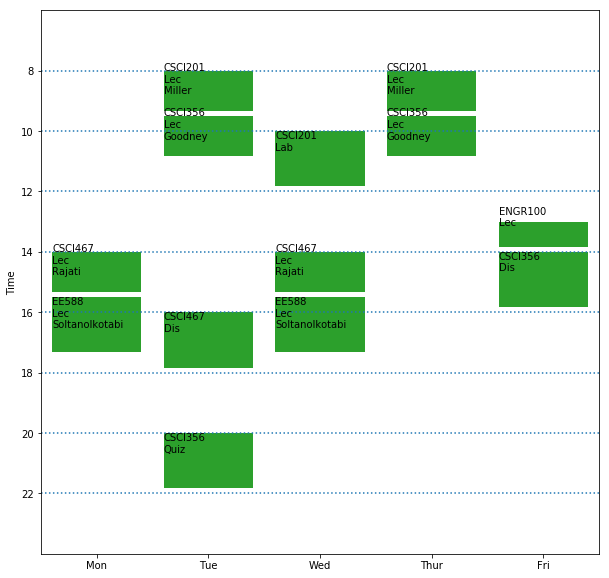

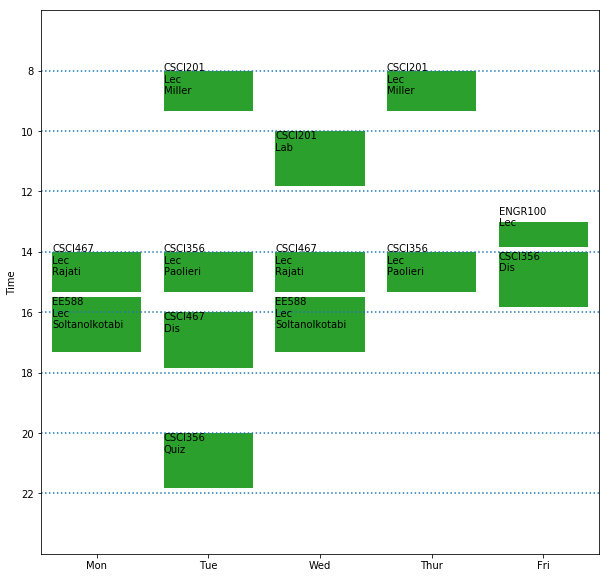

In [369]:
painter = printSchedule()
painter.show_schedule(sortedL[2])
painter = printSchedule()
painter.show_schedule(sortedL[0])

In [262]:
len(sortedL)

10

21.833333333333332